# Classical ML approach
---
---

Imports and Paths
---

In [1]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(sys.path[-1])

/home/cotsios/dsit/2nd-semester/im-anal-and-proc/Img_analysis_assignment_2


In [2]:
BASE_DIR = os.path.dirname(os.getcwd())
DATA_DIR  = os.path.join(BASE_DIR, 'extracted_features')
MODELS_DIR = os.path.join(BASE_DIR, 'models')

print(BASE_DIR)
print(DATA_DIR)
print(MODELS_DIR)

/home/cotsios/dsit/2nd-semester/im-anal-and-proc/Img_analysis_assignment_2
/home/cotsios/dsit/2nd-semester/im-anal-and-proc/Img_analysis_assignment_2/extracted_features
/home/cotsios/dsit/2nd-semester/im-anal-and-proc/Img_analysis_assignment_2/models


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import (
    matthews_corrcoef, f1_score, accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay
)

from src.classical_ml import MySVC

## Model training an SVM
---

I chose to work with an __SVM__ classifier, as I have seen from the previous step ([feature_extraction.ipyn](feature_extraction.ipynb)) that the features extracted are complex and likely not linearly separable, making SVM a suitable choice due to its ability to handle high-dimensional spaces and use kernel functions for effective classification.

I created a class named `MySVC` which uses `mRMR` to find the top $10$ features and `optuna` to tune the hyperparameter space. The hyperparameters tuned are:
- `C`: Regularization parameter. The strength of the regularization is inversely proportional to C. Search space: from $1e-5$ to $1e5$.
- `kernel`: Specifies the kernel type to be used in the algorithm. Search space: __rbf__ and __sigmoid__.
- `gamma`: Kernel coefficient for 'rbf', 'poly' and 'sigmoid'. Search space: __scale__ and __auto__.

After finding the best hyperparameters, an `SVC` is trained on all the training data to produce the final model and saves it in the specified directory. Finally, that model is tested against the holdout set.

In [4]:
df = pd.read_csv(os.path.join(DATA_DIR, "features.csv"))

test_dataframe = df.sample(frac=0.2, random_state=42)
train_dataframe = df.drop(test_dataframe.index)

[I 2025-06-18 19:13:24,109] A new study created in memory with name: no-name-80e3d8c6-0405-4c5f-b101-d454b19bb325


Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]


Best trial finished with MCC: 0.6701994435205122
Best hyperparameters:
  C: 74417.24967520677
  kernel: rbf
  gamma: scale
Performing final feature selection on full training set...
Selected 10 features: ['n_edges', 'vertical_lines', 'hist_std_151_200', 'horizontal_lines', 'fft_mean', 'hist_std_0_50', 'hist_means_151_200', 'hist_std_101_150', 'std', 'hu_moment_4']
Best model trained successfully.
Best model and metadata saved to: /home/cotsios/dsit/2nd-semester/im-anal-and-proc/Img_analysis_assignment_2/models/SVC_best_model.joblib

Best SVC Model: SVC(C=74417.24967520677, random_state=42)


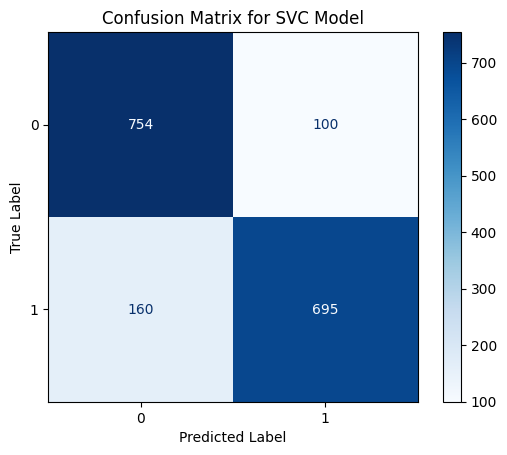

In [5]:
svc_optimizer = MySVC(
    model_dir=MODELS_DIR,
    data=train_dataframe, 
    target="label", 
    optuna_trials=50,
    cv_folds=5,
    max_features=10
)

svc_optimizer.find_best_hyperparameters()

best_svc_model = svc_optimizer.get_best_model()
print("\nBest SVC Model:", best_svc_model)

X_test = test_dataframe.drop(columns=svc_optimizer.target)
y_test = test_dataframe[svc_optimizer.target]

X_test_selected = X_test[svc_optimizer.selected_features]

y_pred_test = best_svc_model.predict(X_test_selected)

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix for SVC Model")
disp.ax_.set_xlabel("Predicted Label")
disp.ax_.set_ylabel("True Label")
plt.show()

In [7]:
print(
    "MCC: "
    f"{matthews_corrcoef(y_test, y_pred_test)}"
)
print(
    "f1 Score: "
    f"{f1_score(y_test, y_pred_test, average='weighted')}"
)
print(
    "Accuracy: "
    f"{accuracy_score(y_test, y_pred_test)}"
)

MCC: 0.6974622459081249
f1 Score: 0.847679632521129
Accuracy: 0.8478642480983031


## Conclusion
---

Using mRMR the selected features are:

- `n_edges`
- `vertical_lines`
- `hist_std_151_200`
- `horizontal_lines`
- `fft_mean`
- `hist_std_0_50`
- `hist_means_151_200`
- `hist_std_101_150`
- `std` 
- `hu_moment_4`

The optimal hyperparameters for the model are:
- `C` = $74417.25$
- `kernel` = __rbf__
- `gamma` = __scale__

On the unseen data, the model performed exceptionally well, especially considering that it only used features extracted from the images, and not the images themselves.